In [1]:
import torch
import torchvision
from torchvision import transforms
from torch import nn, optim
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

import os, copy, time, math
import MiniImageNetTaskSet as ts

/home/erfan/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# fomaml-5way-5shot.ipynb
nway = 5
support_samples = 5
query_samples = 10
dv_mode = 'fo' # fo: first order (FOMAML) - so: second order (MAML)
use_lr_scheduler = False

#-- Running on 1650

In [3]:
meta_train_batch = 4
meta_test_batch = 20

meta_epochs = 20000
base_train_epochs = 5
base_test_epochs = 10

meta_train_rep_freq = 50
meta_test_freq = 200
meta_save_freq = 1000

alpha = 0.01 # base model learning rate
beta = 0.01 # meta model learning rate

ts_train = ts.MiniImageNetTaskSet(mode='train', nway=nway, support_samples=support_samples, query_samples=query_samples)
#ts_val = ts.MiniImageNetTaskSet(mode='val', nway=nway, support_samples=support_samples, query_samples=query_samples)
ts_test = ts.MiniImageNetTaskSet(mode='test', nway=nway, support_samples=support_samples, query_samples=query_samples)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('OK CUDA was avaialbe.')
else:
    device = torch.device('cpu')
print(device)

OK CUDA was avaialbe.
cuda


In [5]:
def acc_f1(y, y_hat):
    p = y_hat.max(1, keepdim=True)[1]
    acc, f1 = accuracy_score(y.cpu(), p.cpu()), f1_score(y.cpu(), p.cpu(), average='macro')
    return acc, f1

In [6]:
def cosine_decay(epoch, beta):
    a = 0.5 * beta * (1 + math.cos(epoch * math.pi / meta_epochs))
    return a

In [7]:
meta_model = nn.Sequential(
    nn.Conv2d(3, 32, (3,3), (1,1)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    
    nn.Conv2d(32, 32, (3,3), (1,1)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(32, 32, (3,3), (1,1)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Conv2d(32, 32, (3,3), (1,1)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),

    nn.Flatten(),
    nn.Linear(288, nway)
)

print(meta_model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, 

In [8]:
def train_base_model(base_model, episode, base_epochs, device, alpha, dv_mode):
    base_model_grads = None # variable to store base model grads after backward propagating Query data loss

    D_sup, D_que = episode # extracting Support and Query data from episode
    X_sup, y_sup = D_sup # extracting Support inputs (X) and labels (y)
    X_que, y_que = D_que # extracting Query inputs (X) and labels (y)
    # assigning Support and Query tensors to device
    X_sup, y_sup = X_sup.to(device), y_sup.to(device)
    X_que, y_que = X_que.to(device), y_que.to(device)

    base_criterion = nn.CrossEntropyLoss() # base model loss function
    base_optimizer = optim.SGD(base_model.parameters(), lr=alpha) # base model optimizer
    
    # training base model on Support data
    base_model.train() # telling pytorch we want to train this base model
    for i in range(base_epochs):
        base_optimizer.zero_grad() # telling pytorch to clear calculated grads from previous computations
        y_sup_hat = base_model(X_sup) # feed forward of all Support inputs for current episode
        base_loss = base_criterion(y_sup_hat, y_sup) # computing the loss of current task Support
        
        # backward propagate derivatives for base model
        base_loss.backward()
        # update base model parameters
        base_optimizer.step()
    
    # testing trained base model on Query data
    else:
        base_model.train() # telling pytroch we want to train this base model
        base_optimizer.zero_grad() # telling pytorch to clear calculated grads from previous computations
        y_que_hat = base_model(X_que) # feed forward of all Query inputs for current episode
        base_que_loss = base_criterion(y_que_hat, y_que) # calculating query loss for base model
        
        if dv_mode == 'fo': # first order grad calc
            base_que_loss.backward() # backward propagating the query loss to calculate parameters gradients w.r.t. query loss
        elif dv_mode == 'so': # second order grad calculation
            base_que_loss.backward(retain_graph=True)
            base_que_loss.backward()


        # storing base model grads w.r.t. Query data loss
        base_model_grads = [param.grad for param in list(base_model.parameters())]
        # storing base model loss over Query data
        base_model_loss = base_que_loss.item()

        # calculating base model's accuracy and F1 score over Query data
        base_model_acc, base_model_f1 = acc_f1(y_que, y_que_hat)

        # removing the base model from gpu to free vram
        del base_que_loss
        del base_loss
        del base_criterion
        del base_optimizer
        del base_model
        torch.cuda.empty_cache()
    
    return base_model_loss, base_model_grads, base_model_acc, base_model_f1
    

In [9]:
def train_meta_model(meta_model, beta, meta_batch, dv_mode, device, ls_base_models_grads, ls_base_models_losses, ls_base_models_acc, ls_base_models_f1):
    # training meta model over a batch of episodes 
    with torch.no_grad():
        _ = meta_model.to(device) # assigning meta model to device

        # a list to store meta model parameters grads
        meta_model_grads = [torch.zeros_like(param) for param in ls_base_models_grads[0]] 
        
        # creating meta model parameters grads
        for base_model_grads in ls_base_models_grads: # for each base model
            for grad_index in range(len(base_model_grads)): # for each base model's parameter's grad
                base_model_grad = base_model_grads[grad_index] # get base model grad
                # create meta model parameter grad 
                meta_model_grads[grad_index] += (1/meta_batch) * base_model_grad


        # updating meta model parameter
        for param, grad in zip(meta_model.parameters(), meta_model_grads):
            new_param = param - beta * grad
            param.copy_(new_param)
        
    # calculate meta training loss, acc, f1 by averaging base models' losses, acc, f1
    meta_loss = sum(ls_base_models_losses) / meta_batch 
    meta_acc = sum(ls_base_models_acc) / meta_batch
    meta_f1 = sum(ls_base_models_f1) / meta_batch

    return meta_model, meta_loss, meta_acc, meta_f1
    

In [10]:
ls_meta_train_metrics = []
ls_meta_test_metrics = []

time_begin = time.time()

for meta_i in range(1, meta_epochs+1):
    # sample meta_batch tasks
    train_episodes = ts_train.sample_episodes(meta_train_batch)

    ls_base_models_grads = []
    ls_base_models_losses = []
    ls_base_models_acc = []
    ls_base_models_f1 = []

    for episode, ep_i in zip(train_episodes, range(len(train_episodes))):
        base_model = copy.deepcopy(meta_model) # copy parameters of meta model to base model
        _ = base_model.to(device) # assign base model to device

        # training base model on Support and Calculate it's Gradients w.r.t. Query data
        base_model_loss, base_model_grads, base_model_acc, base_model_f1 = train_base_model(base_model, 
                                                                                            episode, 
                                                                                            base_train_epochs, 
                                                                                            device, 
                                                                                            alpha,
                                                                                            dv_mode)
        
        ls_base_models_losses.append(base_model_loss)
        ls_base_models_grads.append(base_model_grads)
        ls_base_models_acc.append(base_model_acc)
        ls_base_models_f1.append(base_model_f1)
    
    
    # training meta model w.r.t. base models' gradients
    lr = beta if not use_lr_scheduler else cosine_decay(meta_i, beta)
    meta_model, meta_train_loss, meta_train_acc, meta_train_f1 = train_meta_model(meta_model, 
                                                                lr,
                                                                meta_train_batch, 
                                                                dv_mode,
                                                                device, 
                                                                ls_base_models_grads, 
                                                                ls_base_models_losses, 
                                                                ls_base_models_acc, 
                                                                ls_base_models_f1)
    
    ls_meta_train_metrics.append((meta_train_loss, meta_train_acc, meta_train_f1))
    
    # storing model checkpoint
    if meta_i%meta_save_freq == 0:
        torch.save(meta_model.state_dict(), os.path.join('models', f'model_{meta_i}_{nway}way_{support_samples}shot_{dv_mode}{"_COS" if use_lr_scheduler else ""}.pt'))

    # reporting back to user
    if meta_i%meta_train_rep_freq == 0:
        print(f'- Meta Epoch: {meta_i}, meta loss: {meta_train_loss}, meta acc: {round(meta_train_acc, 3)}, meta f1: {round(meta_train_f1, 3)}, took: {round(time.time()-time_begin, 1)} secs')
        time_begin = time.time()

    # meta testing
    if meta_i%meta_test_freq == 0:
        time_begin = time.time()
        test_episodes = ts_test.sample_episodes(meta_test_batch)
        ls_test_models_losses = []
        ls_test_models_acc = []
        ls_test_models_f1 = []

        for episode, ep_i in zip(test_episodes, range(len(test_episodes))):
            test_model = copy.deepcopy(meta_model) # copy parameters of meta model to val model
            _ = test_model.to(device) # assign base model to device

            # training val model on Support and Calculate it's loss, f1 and acc w.r.t. Query data
            test_model_loss, _, test_model_acc, test_model_f1 = train_base_model(test_model, episode, base_test_epochs, device, alpha, dv_mode)
        
            ls_test_models_losses.append(test_model_loss)
            ls_test_models_acc.append(test_model_acc)
            ls_test_models_f1.append(test_model_f1)
    
        # calculate meta validation loss, acc, f1 by averaging validation models' losses, acc, f1
        meta_test_loss = sum(ls_test_models_losses) / meta_test_batch 
        meta_test_acc = sum(ls_test_models_acc) / meta_test_batch
        meta_test_f1 = sum(ls_test_models_f1) / meta_test_batch
        ls_meta_test_metrics.append((meta_test_loss, meta_test_acc, meta_test_f1))

        print(f'[META TEST]- Meta Epoch: {meta_i}, meta loss: {meta_test_loss}, meta acc: {round(meta_test_acc, 3)}, meta f1: {round(meta_test_f1, 3)}, took: {round(time.time()-time_begin, 1)} secs')
        time_begin = time.time()


- Meta Epoch: 50, meta loss: 1.3094824254512787, meta acc: 0.495, meta f1: 0.486, took: 23.8 secs
- Meta Epoch: 100, meta loss: 1.4001331329345703, meta acc: 0.405, meta f1: 0.401, took: 21.6 secs
- Meta Epoch: 150, meta loss: 1.2981397211551666, meta acc: 0.5, meta f1: 0.487, took: 21.9 secs
- Meta Epoch: 200, meta loss: 1.3618994057178497, meta acc: 0.45, meta f1: 0.443, took: 22.3 secs
[META TEST]- Meta Epoch: 200, meta loss: 1.4358180820941926, meta acc: 0.421, meta f1: 0.414, took: 3.3 secs
- Meta Epoch: 250, meta loss: 1.3361030220985413, meta acc: 0.46, meta f1: 0.453, took: 22.5 secs
- Meta Epoch: 300, meta loss: 1.3659345209598541, meta acc: 0.52, meta f1: 0.502, took: 22.5 secs
- Meta Epoch: 350, meta loss: 1.4339017570018768, meta acc: 0.415, meta f1: 0.405, took: 22.6 secs
- Meta Epoch: 400, meta loss: 1.479922205209732, meta acc: 0.365, meta f1: 0.359, took: 22.6 secs
[META TEST]- Meta Epoch: 400, meta loss: 1.4570075035095216, meta acc: 0.409, meta f1: 0.404, took: 3.3 se

Text(0.5, 1.0, 'Meta Training Loss Plot')

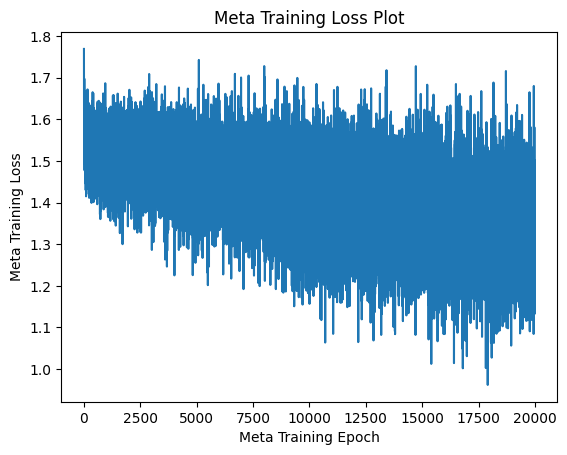

In [ ]:
ls_meta_train_losses = [item[0] for item in ls_meta_train_metrics]
plt.plot(ls_meta_train_losses)
plt.xlabel('Meta Training Epoch')
plt.ylabel('Meta Training Loss')
plt.title('Meta Training Loss Plot')

Text(0.5, 1.0, 'Meta Training Accuracy Plot')

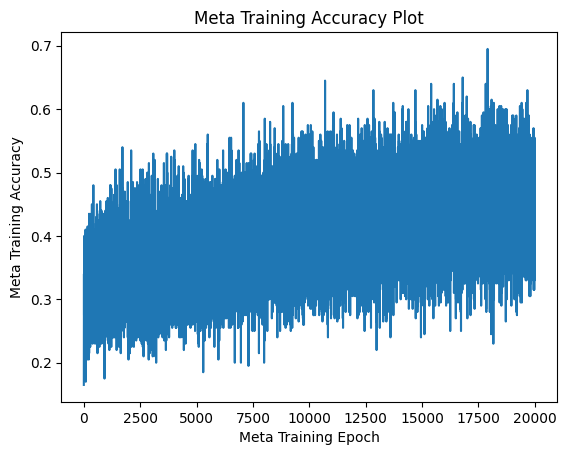

In [ ]:
ls_meta_train_acc = [item[1] for item in ls_meta_train_metrics]
plt.plot(ls_meta_train_acc)
plt.xlabel('Meta Training Epoch')
plt.ylabel('Meta Training Accuracy')
plt.title('Meta Training Accuracy Plot')

Text(0.5, 1.0, 'Meta Training F1-Score Plot')

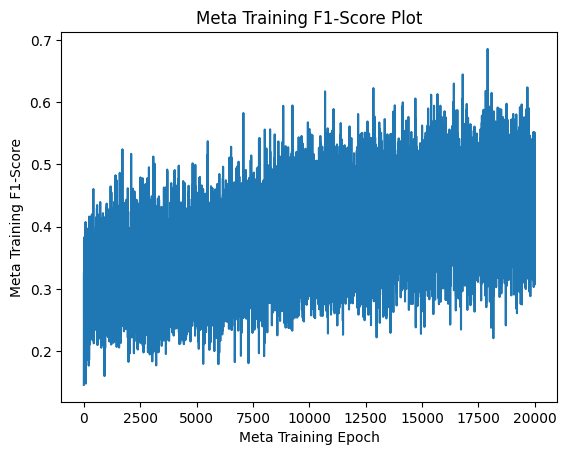

In [ ]:
ls_meta_train_f1 = [item[2] for item in ls_meta_train_metrics]
plt.plot(ls_meta_train_f1)
plt.xlabel('Meta Training Epoch')
plt.ylabel('Meta Training F1-Score')
plt.title('Meta Training F1-Score Plot')

Text(0.5, 1.0, 'Meta Testing Loss Plot')

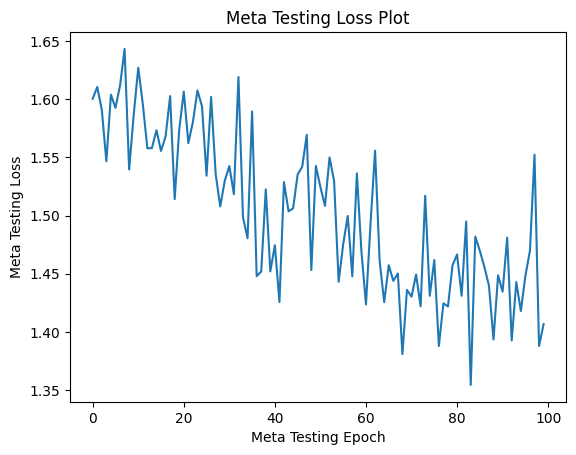

In [ ]:
ls_meta_test_losses = [item[0] for item in ls_meta_test_metrics]
plt.plot(ls_meta_test_losses)
plt.xlabel('Meta Testing Epoch')
plt.ylabel('Meta Testing Loss')
plt.title('Meta Testing Loss Plot')

Text(0.5, 1.0, 'Meta Testing Accuracy Plot')

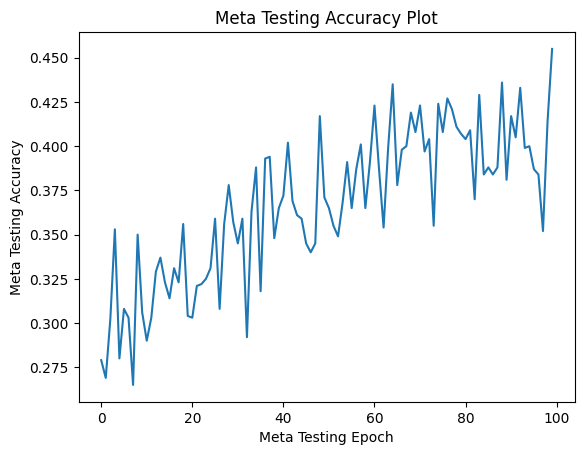

In [ ]:
ls_meta_test_acc = [item[1] for item in ls_meta_test_metrics]
plt.plot(ls_meta_test_acc)
plt.xlabel('Meta Testing Epoch')
plt.ylabel('Meta Testing Accuracy')
plt.title('Meta Testing Accuracy Plot')

Text(0.5, 1.0, 'Meta Testing F1-Score Plot')

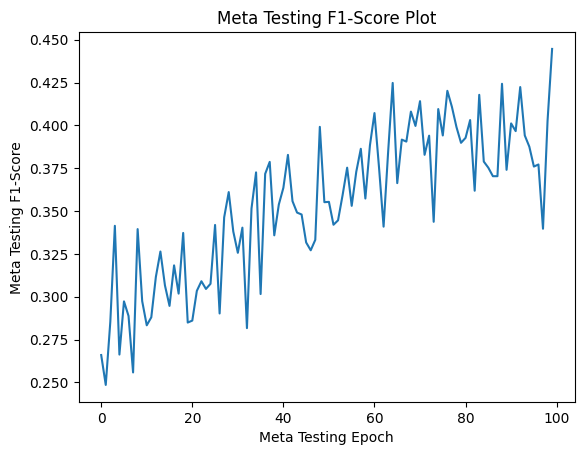

In [ ]:
ls_meta_test_f1 = [item[2] for item in ls_meta_test_metrics]
plt.plot(ls_meta_test_f1)
plt.xlabel('Meta Testing Epoch')
plt.ylabel('Meta Testing F1-Score')
plt.title('Meta Testing F1-Score Plot')

In [ ]:
import pandas as pd

In [ ]:
df_test = pd.DataFrame(ls_meta_test_metrics, columns=['loss', 'acc', 'f1'])
df_train = pd.DataFrame(ls_meta_train_metrics, columns=['loss', 'acc', 'f1'])

df_test.to_csv('test_metrics.csv', index=False)
df_train.to_csv('train_metrics.csv', index=False)